In [1]:
images_dir = "spineUltrasounda"

In [36]:
from local_vars import root_folder

from keras.layers import Input
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D

from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import  Model
from keras.optimizers import Adam, rmsprop
from keras import losses
from keras.layers import concatenate, Add
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt
import cv2

import numpy as np

import os
import shutil

patch_size = 128

category = True

import keras.utils

import numpy as np
import keras

import scipy


def nvidia_unet(patch_size=128):
    input_ = Input((patch_size, patch_size, 1))
    skips = []
    output = input_
    for shape, filters in zip([5, 3, 3, 3, 3, 3, 3], [16, 32, 64, 64, 64, 64, 64]):
        skips.append(output)
        print(output.shape)
        output= Conv2D(2*filters, (shape, shape), strides=2, padding="same", activation="relu")(output)
        #output = BatchNormalization()(output)
        #if shape != 7:
        #   output = BatchNormalization()(output)
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4, 4], [64, 64, 64, 64,32, 16, 2]):
        output = keras.layers.UpSampling2D()(output)
        
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=3)
        
        if filters != 2:
            activation = "relu"
        else:
            activation = "softmax"
        output = Conv2D(2*filters if filters != 2 else 2, (shape, shape), activation=activation, padding="same")(output)
        
        
            
        if filters != 2:
            output = BatchNormalization(momentum=.9)(output)
    assert len(skips) == 0
    return Model([input_], [output])
models = [nvidia_unet() for _ in range(2)]
[model.compile(optimizer=keras.optimizers.adam(), loss= "mean_squared_error") for model in models]
loss = [[] for _ in range(2)]
models[1].summary()

(?, 128, 128, 1)
(?, 64, 64, 32)
(?, 32, 32, 64)
(?, 16, 16, 128)
(?, 8, 8, 128)
(?, 4, 4, 128)
(?, 2, 2, 128)
(?, 128, 128, 1)
(?, 64, 64, 32)
(?, 32, 32, 64)
(?, 16, 16, 128)
(?, 8, 8, 128)
(?, 4, 4, 128)
(?, 2, 2, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 64, 64, 32)   832         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 32, 32, 64)   18496       conv2d_43[0][0]                  
_____________________________________________________________________________________

In [3]:
data = np.array( np.load(os.path.join(root_folder, images_dir, "ultrasound.npy" )), np.float)
classes = np.array(np.load(os.path.join(root_folder, images_dir, "segmentation.npy")), np.float)
#classes = np.concatenate([classes, 1 - classes], -1)
tdata = np.array( np.load(os.path.join(root_folder, images_dir, "ultrasound-test.npy" )), np.float)
tclasses = np.array(np.load(os.path.join(root_folder, images_dir, "segmentation-test.npy")), np.float)
#tclasses = np.concatenate([tclasses, 1 - tclasses], -1)

In [4]:
def dialateStack(array, iterations):
    return np.array([scipy.ndimage.binary_dilation(y_e, iterations=iterations) for y_e in array])

width = 7
test_y_dialated = dialateStack(tclasses[:, :, :, 0], width)
t_final_x = []
t_final_y = []
for i in range(len(tdata)):

    
    t_final_x.append(cv2.resize(tdata[i], (128, 128)))
    t_final_y.append(cv2.resize(test_y_dialated[i] + 0.0, (128, 128)))
tdata =  np.expand_dims(t_final_x, -1)
test_y_dialated = np.array(t_final_y)

test_y_dialated = np.expand_dims(test_y_dialated, -1)
tclasses_dialated = np.concatenate([test_y_dialated, 1-test_y_dialated], -1)


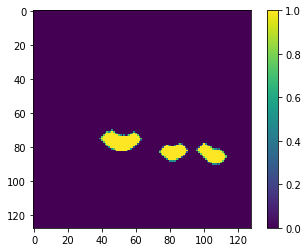

In [9]:
i = np.random.randint(10)
plt.imshow(tclasses_dialated[i, :, :, 0])
plt.colorbar()
plt.show()

In [50]:
import scipy
import cv2
import matplotlib.pyplot as plt
for width in [9, 9, 9]:
    y_edge = np.array([scipy.ndimage.binary_dilation(y_e, iterations=width) for y_e in classes])[:, :] * 1.0
    for _ in range(170):
        #augment by rotation
        print("rotation")
        angle = np.random.randint(-7, 7)   
        batchx = scipy.ndimage.interpolation.rotate(data, angle, (1, 2), False, mode="constant", cval=0)
        batchy = scipy.ndimage.interpolation.rotate(y_edge, angle, (1, 2), False, mode="constant", cval=-1)
        
        batchx = np.clip(batchx, 0, 1)
        print(batchx.shape)

        #batchx = np.concatenate([batchx, -batchx]) / 255.

        print("scaling")
        maxcrop = 20
        shape = batchx[0].shape
        
        final_x = []
        final_y = []
        for i in range(len(batchx)):
            
            while True:
                
                x1 = np.random.randint(0, maxcrop)
                x2 = np.random.randint(256 - maxcrop, 256)

                y1 = np.random.randint(0, maxcrop)
                y2 = np.random.randint(256 - maxcrop, 256)

                y_test = batchy[i, x1:x2, y1:y2]

                if not(np.any(y_test == -1)):
                    break
            
            final_x.append(cv2.resize(batchx[i, x1:x2, y1:y2], (128, 128)))
            final_y.append(cv2.resize(batchy[i, x1:x2, y1:y2], (128, 128)))
            
        print("duplicating")
        
        
        batchx = np.array(final_x)
        batchy = np.array(final_y)
        
        print(batchx.shape)
        print(batchy.shape)
        batchx = np.expand_dims(batchx, -1)

        batchy = np.expand_dims(batchy, -1)
        batchy = np.concatenate([batchy, 1-batchy], -1)
        
        batchx = np.concatenate([batchx, np.flip(batchx, 2)])
        batchy = np.concatenate([batchy, np.flip(batchy, 2)])
        
        #batchx = np.concatenate([batchx, np.flip(batchx, 1)])
        #batchy = np.concatenate([batchy, np.flip(batchy, 1)])
        
        #batchx = np.concatenate([batchx, np.transpose(batchx, (0, 2, 1, 3))])
        #batchy = np.concatenate([batchy, np.transpose(batchy, (0, 2, 1, 3))])
        
        #offset = np.random.random((len(batchx), 1, 1, 1)) / 4 - .125
        #scale = np.random.random((len(batchx), 1, 1, 1)) / 2 + .75
 
        #batchx = scale * batchx + offset
    
        scale = np.random.uniform(-1.4, 1.4, (len(batchx), 1, 1, 1))


        batchx = (batchx + 0.0) ** ( 2.5 **scale)
            
        
    
        
        for i in range(2):
            l = models[i].fit(batchx, batchy, validation_data=(tdata, tclasses_dialated), batch_size=len(batchx) // 12)
            loss[i].append(l)

rotation
(116, 256, 256, 1)
scaling
duplicating
(116, 128, 128)
(116, 128, 128)
Train on 232 samples, validate on 13 samples
Epoch 1/1
232/232 [==============================] - 2s 10ms/step - loss: 0.0164 - val_loss: 0.0098
Train on 232 samples, validate on 13 samples
Epoch 1/1
232/232 [==============================] - 2s 9ms/step - loss: 0.0166 - val_loss: 0.0066
rotation
(116, 256, 256, 1)
scaling
duplicating
(116, 128, 128)
(116, 128, 128)
Train on 232 samples, validate on 13 samples
Epoch 1/1
232/232 [==============================] - 2s 9ms/step - loss: 0.0161 - val_loss: 0.0053
Train on 232 samples, validate on 13 samples
Epoch 1/1
232/232 [==============================] - 2s 9ms/step - loss: 0.0161 - val_loss: 0.0071
rotation
(116, 256, 256, 1)
scaling
duplicating
(116, 128, 128)
(116, 128, 128)
Train on 232 samples, validate on 13 samples
Epoch 1/1
232/232 [==============================] - 2s 9ms/step - loss: 0.0158 - val_loss: 0.0049
Train on 232 samples, validate on 13 sa

KeyboardInterrupt: 

(13, 128, 128, 1)

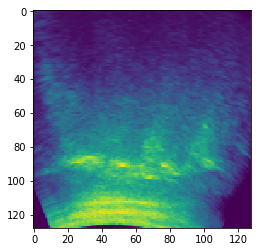

In [28]:
plt.imshow(batchx[0, :, :, 0])
tdata.shape


In [51]:
result = models[0].predict(batchx)

ValueError: Error when checking input: expected input_3 to have shape (128, 128, 1) but got array with shape (256, 256, 1)

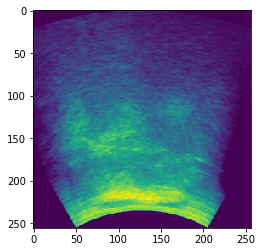

IndexError: index 92 is out of bounds for axis 0 with size 13

In [52]:
j = np.random.randint(120)
plt.imshow(batchx[j, :, :, 0])
plt.show()
plt.imshow(result[j, :, :, 0])
plt.colorbar()
plt.show()

plt.imshow(batchy[j,:, :, 0])
plt.show()

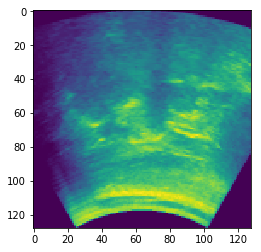

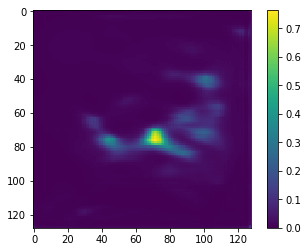

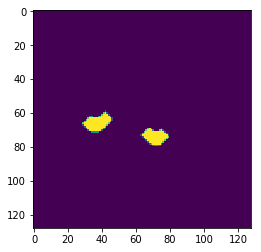

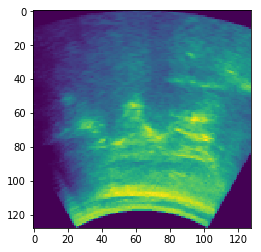

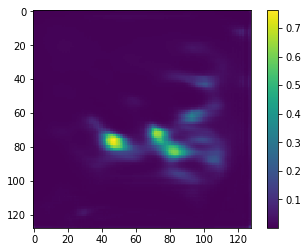

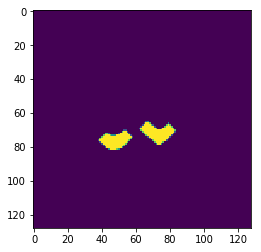

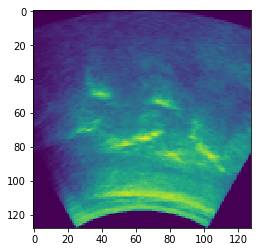

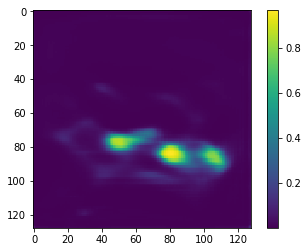

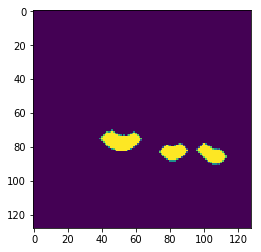

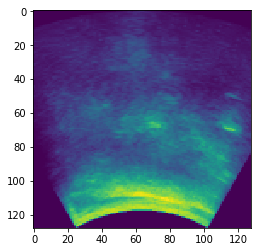

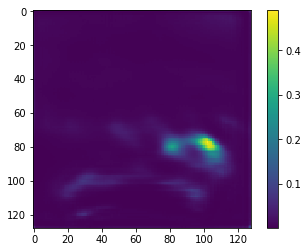

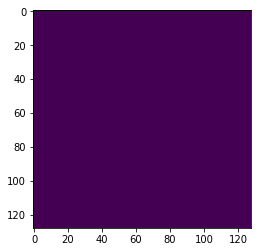

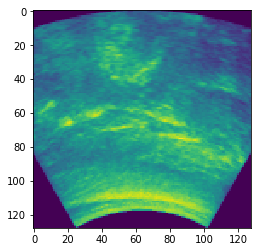

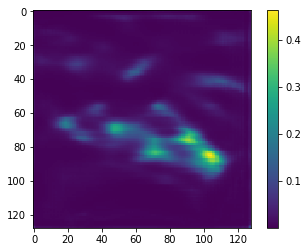

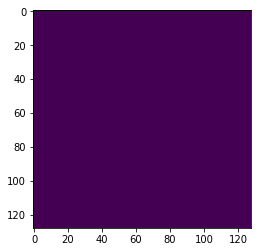

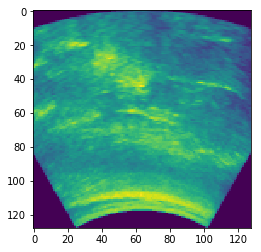

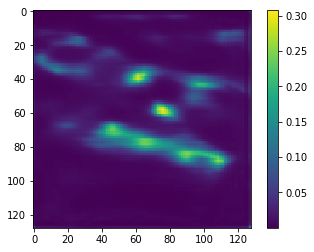

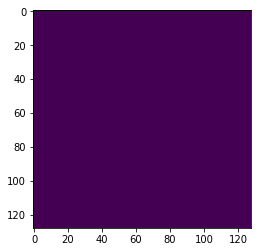

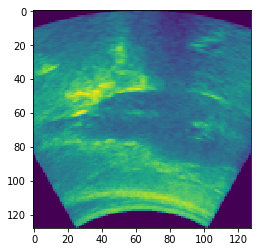

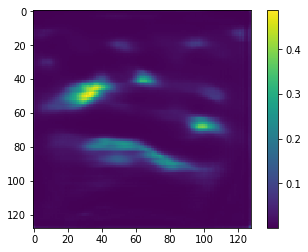

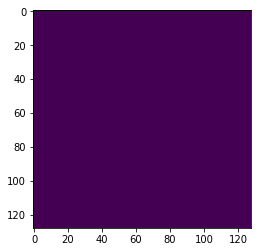

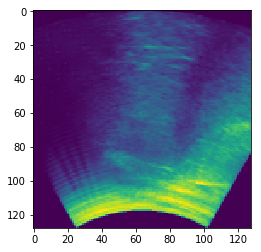

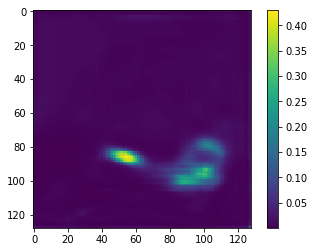

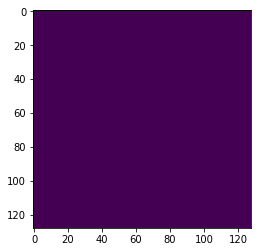

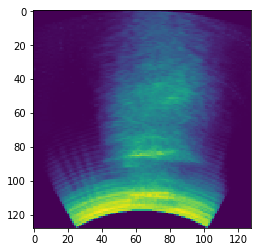

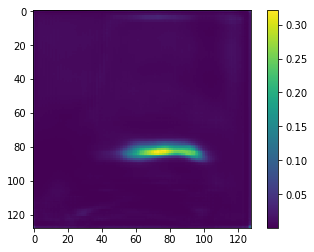

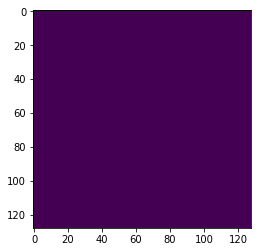

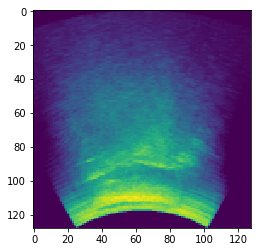

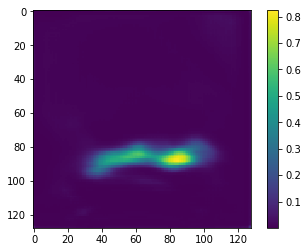

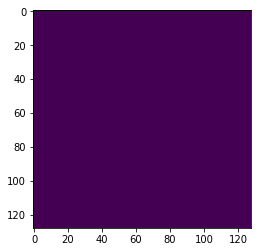

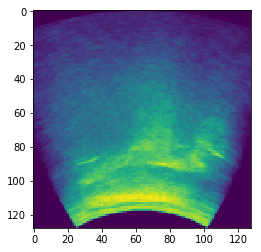

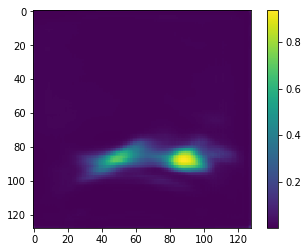

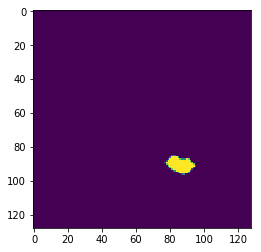

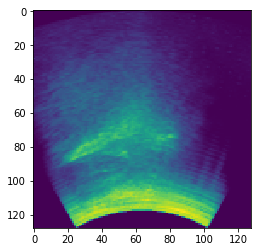

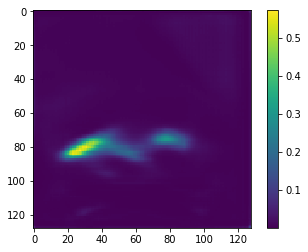

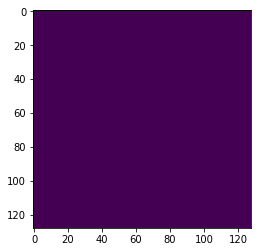

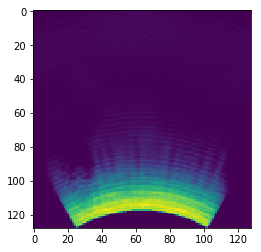

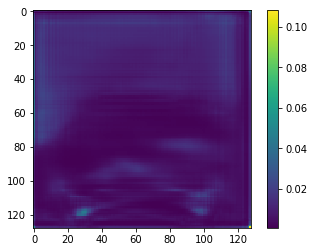

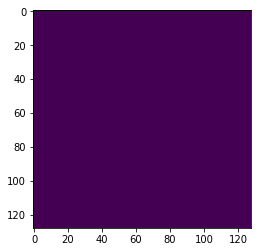

In [57]:
for _ in range(13):
    result = models[0].predict(tdata)

    j = _
    plt.imshow(tdata[j, :, :, 0])
    plt.show()
    plt.imshow(result[j, :, :, 0])
    plt.colorbar()
    plt.show()

    plt.imshow(tclasses_dialated[j,:, :, 0])
    plt.show()

In [59]:
models[0].save("5_10_19_model.h5")
